In [143]:
import spacy
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
# import difflib
import jellyfish
import pandas as pd
import numpy as np
import itertools
import nltk
from string import punctuation as PUNCTUATIONS
import sklearn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
# from ggplot import *

NEGATIONS = ['not','neither','never','no','nobody','none','nor','nothing','nowhere',
             'without','hardly','lack','barely','rarely','seldom'] # exclude negations from stopwords 

            
pd.options.display.max_colwidth=999
pd.options.display.max_rows=10000

In [144]:
'''
-- * customer_reviews.csv *-----------------------
SELECT reviewid, title, reviewtext, rating, adv_uid
  FROM consumerreview_cdc.REVIEW
  where ModerationStatus = 'APPROVED'
'''

cr_df_all = pd.read_csv('customer_reviews.csv', header=0, low_memory=False)
# cr_df = cr_df_all.iloc[:2000,]
cr_df = cr_df_all
cr_df.head(10)
cr_df.shape

(17263, 5)

In [145]:
nlp = spacy.load('en')
cr_df.head(10)


REVIEWID                                         TITLE  \
0  64853844                           Outstanding Service   
1  64826090     Redundant steps made process way too long   
2  64850780                             great experience    
3  64853793                Great experience and best rate   
4  64845204                    Very Positive Experience !   
5  64834453                                 They did good   
6  64847195          Unbelievably Competent and Efficient   
7  52205332  Now wish to procure another home with PMA :)   
8  64851143                                        Great    
9  48738095                        Fantastic experience !   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  REVIEWTEXT  \
0                                                                                                                                                            My wife and I used Optimum First Mortgage to refinance a home loan. We shopped around for the best available rate and luckily found this company. We had the pleasure of working with Tim Williams. It was our first time doing a refinance and Tim did an absolute good job explaining in detail the refinance process, being always available and answering every single question my wife and I had. In all, the whole refinance process was made easy, Tim delivered on his promises and we couId not be more satisfied. Tim and OFM were very professional, prompt and most importantly, honest. I would highly recommend Optimum First Mortgage to anyone.   
1  The refinance seemed to go smoothly.  They never indicated any problems, and were always courteous and professional.  Any questions I had were answered over the phone or emailed.  However, I was asked to sign the same documents online and then on hard copies sent overnight, and then again upon closing.  I also received several emails that were computer-generated telling me my refinance was "conditionally approved" depending on  In spite of their claims that they are self-funded, my loan was held up by requests for further documentation from their underwriters (e.g. two phone calls and an email to verify my employment--already indicated by W-2s and tax returns).  In the end, my refinance, which I was told would take about 30 days, took over 100 days.\r\n\r\nI cannot recommend eRates.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       everything went very smooth and fast   
3                                                                                                                                  

### Token/lemma filtered by POS and Dep

In [146]:
def do_nlp_process(data):

    tokens = []
    text_ = []
    text_lemma = []
    nouns = []
    namedEnt = []
    DependencyParDict = {}

    for doc in nlp.pipe(data, batch_size=1000, n_threads=-1):
        # String Text in Lemma 
        text_lemma.append(
            " ".join([tk.lemma_ if tk.lemma_ != '-PRON-' else tk.text.lower() for tk in doc])
        ) 
        # String text with more process 
        text_.append(" ".join([tk.lemma_ for tk in doc 
            if ((tk.lemma_ not in ENGLISH_STOP_WORDS) or (tk.lemma_ in NEGATIONS)) 
            and tk.lemma_ not in PUNCTUATIONS 
            and tk.lemma_ != '-PRON-'
            and tk.dep_ not in ['punct']
            and tk.pos_ not in ['PUNCT','SPACE','PROPN']
            and not(tk.dep_=='pobj' and tk.pos_=='NOUN')
            and (tk.pos_!='NUM' or (tk.pos_ == 'NUM' and tk.head.lemma_ in ['day','week','month','score','star']))
         ]))
        # List of tokens
        tokens.append([tk.lemma_ for tk in doc 
            if ((tk.lemma_ not in ENGLISH_STOP_WORDS) or (tk.lemma_ in NEGATIONS)) 
            and tk.lemma_ not in PUNCTUATIONS 
            and tk.lemma_ != '-PRON-'
            and tk.dep_ not in ['punct']
            and tk.pos_ not in ['PUNCT','SPACE','PROPN']
            and not(tk.dep_=='pobj' and tk.pos_=='NOUN')
            and (tk.pos_!='NUM' or (tk.pos_ == 'NUM' and tk.head.lemma_ in ['day','week','month','score','star']))
         ])

        ### Noun Entity Recognize, Named Entity Recognition
        nouns.extend(list(doc.noun_chunks))
        namedEnt.extend(list(doc.ents)) 
    return (text_lemma, tokens, text_, nouns, namedEnt)
                    
cr_df['Text_lemma'],cr_df['Tokens'],cr_df['Text_processed'],nouns, namedEnt = do_nlp_process(cr_df.REVIEWTEXT.astype('unicode').values) #  input to TopicModeling

cr_df.head(100)


REVIEWID                                               TITLE  \
0   64853844                                 Outstanding Service   
1   64826090           Redundant steps made process way too long   
2   64850780                                   great experience    
3   64853793                      Great experience and best rate   
4   64845204                          Very Positive Experience !   
5   64834453                                       They did good   
6   64847195                Unbelievably Competent and Efficient   
7   52205332        Now wish to procure another home with PMA :)   
8   64851143                                              Great    
9   48738095                              Fantastic experience !   
10  64851180                                    Great Experience   
11  64838894             Phenomenal Loan Officer: Thomas Galatis   
12  64829919                                      Piece of cake!   
13  40218110                                   Highly recommende   
14  64847649                                      Easy Easy Easy   
15  64836266                                        Awesome Team   
16  64837814                         Great teamwork by both ends   
17  64824301            Extremely happy with mortgage refinance!   
18  64833019                                        professional   
19  63099528                                   Terrific service!   
20  46479165                        A great Company to work with   
21  49994798      HIgh Tech and very automated and user friendly   
22  64827287              Personal and professional - well done!   
23  64847194                  I will recommend them to everyone!   
24  64845908                                    Great experience   
25  64829376                                 Amazing Experience!   
26  64850784                       2nd time - Great as the First   
27  48556857                               Fantastic Experience!   
28  64853238                                    Great Experience   
29  64848366                                   Excellent Service   
30  50040124  Very competitive rates, low fees and great service   
31  53046811                            AmeriSave was wonderful!   
32  64844856                 Efficient, Professional and Speedy!   
33  64834758               Efficient, Clear and Painless Process   
34  48301666                                                 NaN   
35  64845246                                   Great Experience!   
36  57737958                                   Optimum is great!   
37  64844942                                          Satisfied    
38  64836103                                    Great Experience   
39  64829348                                 Deceptive Practices   
40  64845977                    Not reliable for Texas refinance   
41  64847137                                   Great experience!   
42  64833177                                    Great Experience   
43  54098050                             skeptic turned believer   
44  42763401  Great Customer Service throughout the loan process   
45  64850594                       Great experience and get rate   
46  63236457                              Great Mortgage company   
47  64827469                             Wonderful to work with!   
48  64827714                           Could not ask for better!   
49  64847188               Thanks to Ray and Alyssa-GMH Mortgage   
50  64839133                            Very easy and great rate   
51  64827213              One Of The Best For Mortgage Financing   
52  64829406                             Outstanding Experience!   
53  64853809                                   Very Professional   
54  64122052                               Optimum First Motgage   
55  48567408                                   Excellent Service   
56  64856481                                    Great Experience   
57  64833163                                           Excel

### NounChunks and Named Entity Recognize

In [147]:
def get_namedEntity_list(data):
    # NER including persons, date, time, money, percent, companies, locations, organizations and products...
    PERSON = [ner.lemma_ for ner in list(set(data)) if ner.label_  in ['PERSON','ORG']] # NamedEntity Persons
    result_list = [ner.lemma_ for ner in list(set(data))
                    if len(ner.lemma_.split())>1 #and len(ner.text.split())<=2 
                     and ner.label_ not in ['PERSON','TIME','ORG','CARDINAL','GPE','PRODUCT']
                     ] # contains digits for Date, Time, Percent, Money...
    return result_list


def get_Nouns_list(data):
    # nouns extraction without stopwords (except negation), digits, PERSON names
    result_list = [" ".join([i for i in ner.lemma_.split() if (i not in ENGLISH_STOP_WORDS) or (i in NEGATIONS)]) 
                  for ner in list(set(data)) 
                  if len(ner.lemma_.split())>1 #and len(ner.text.split())<=2 # only bi_grams
                  and ('-PRON-' not in ner.lemma_.split())
                  and all([(i not in PUNCTUATIONS and i.isalpha() and len(i)>1) for i in ner.lemma_.split()]) # letter only
                  ]
    result_list = [i for i in list(set(result_list)) if len(i.split()) > 1 and i not in PERSON]
    return result_list

namedEnt_list = get_namedEntity_list(namedEnt)
nouns_list = get_Nouns_list(nouns)




In [148]:
[print(i) for i in nouns_list[:10]]

incredibly slow feedback
picky customer expectation
bad mortgage experience
tricky credit issue
loan process
time expectation
relatively quick closing
certain agent
good home purchasing experience
no payment


[None, None, None, None, None, None, None, None, None, None]

### Collocation

In [149]:
def get_collocation(data):
    N_TOP_COL = 100 # number of top collocations
    words = []
    for t in data:
        words += t 

    bgm    = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_words(words)
    scored = finder.score_ngrams( bgm.likelihood_ratio  )
    finder.apply_freq_filter(min_freq = 1)
    colls = finder.nbest(bgm.likelihood_ratio, N_TOP_COL)
    collocation = [" ".join(col) for col in colls]
    # tri_gm   = nltk.collocations.BigramAssocMeasures()
    # finder_tri = nltk.collocations.TrigramCollocationFinder.from_words(words)
    # scored_tri = finder_tri.score_ngrams(tri_gm.raw_freq)
    # print(scored_tri)
    return collocation


collocation = get_collocation(cr_df.Tokens)



### n_gram by intersecting Nouns, NER and Collocation


In [150]:

bi_grams = list(set(nouns_list).union(set(namedEnt_list)).union(set(collocation)))
bi_grams[:10]
# len(bi_grams)


['incredibly slow feedback',
 'picky customer expectation',
 'bad mortgage experience',
 'tricky credit issue',
 'loan process',
 'the 2nd day',
 'time expectation',
 'relatively quick closing',
 'certain agent',
 'good home purchasing experience']

### Topic modeling

In [151]:
nlp_vec = spacy.load('en_vectors_web_lg')

def create_vocabulary(data, n_grams):
    # Create custom Vocabulary 
    vectorizer = CountVectorizer(stop_words=None, lowercase=False, max_df=0.9, min_df=0.005)
    X = vectorizer.fit_transform(data)
    vocabulary_ = vectorizer.get_feature_names()

    # extend Vocal with n_grams
    vocabulary_.extend(n_grams)
    vocabulary_processed = [x for x in vocabulary_ if (len(x.split())>1 or x.isalpha())] # more than one letter
    return vocabulary_processed

vocabulary = create_vocabulary(cr_df.Text_processed, bi_grams)

In [171]:
def get_topic_words(modelName, data, vocabulary, no_top_words= 5, no_topics = 20, apply_transform=True):
    
    if modelName == 'NMF':
        vectorizer = TfidfVectorizer(stop_words=None, lowercase=False, vocabulary=vocabulary)
        fitdata = vectorizer.fit_transform(data)
        model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(fitdata)
    elif modelName == 'LDA':
        vectorizer = CountVectorizer(stop_words=None, lowercase=False, vocabulary=vocabulary)
        fitdata = vectorizer.fit_transform(data)        
        model = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(fitdata)
    else:
        print("choose modelName ['NMF' or 'LDA']")
        pass
    
    if apply_transform:
        X = model.transform(fitdata)
        cr_df['topic_vec'] = pd.Series(list(X))
        names = [str(i) for i in range(no_topics)]
        cr_df[names] = pd.DataFrame(cr_df.topic_vec.values.tolist(), index= cr_df.index)

    topic_words = []
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        topic_words.append(" ".join([feature_names[i] 
                        for i in topic.argsort()[:-no_top_words - 1:-1] if feature_names[i] not in ENGLISH_STOP_WORDS]))
    return(topic_words)

no_topics = 30
no_top_words = 4
textData = cr_df.Text_lemma.values # use original text as input
topic_words = get_topic_words('NMF', textData, vocabulary, no_top_words, no_topics, True)
# topic_words = get_topic_words('LDA', cr_df.Text_processed, vocabulary_processed, 5, 20)

topic_words


['company say ask',
 'process entire explain contact',
 'great job experience communication',
 'highly recommend knowledgeable way',
 'loan officer processor need',
 'bank internet local big',
 'question answer available quickly',
 'service customer provide outstanding',
 'easy process online document',
 'good experience overall far',
 'work pleasure hard responsive',
 'home purchase new buy',
 'smooth process transaction closing',
 'professional knowledgeable responsive friendly',
 'refinance year just complete',
 'team responsive rest thank',
 'smoothly quickly glad contact',
 'mortgage company need look',
 'quicken second experience glad',
 'helpful extremely knowledgeable friendly',
 'start finish week just',
 'close time day week',
 'quick respond painless response',
 'use definitely future time',
 'fast efficient friendly super',
 'rate low cost closing',
 'friend family definitely recommend',
 'help thank step way',
 'make sure simple process',
 'excellent communication job prov

In [172]:
def get_topic2tag_dict(data, topic_tags, score_threshold = 0.8):
    #score_threshold : similarity threshold to categorize the latent topics with taglist
    topic2tag_dict = {}
    topic2tag_dict2 = {}
    for tidx, topic in enumerate(topic_words):
        topic_nlp = nlp_vec(topic)
        scores = [t.similarity(topic_nlp) for t in nlp_vec.pipe(topic_tags)]
        topic2tag_dict[str(tidx)] = [topic_tags[i] for i, v in enumerate(scores) if v>=score_threshold]
        topic2tag_dict2[(tidx, topic)]  = [topic_tags[i] for i, v in enumerate(scores) if v>=score_threshold]
    return (topic2tag_dict, topic2tag_dict2)

def get_tag2topic_dict(data):
    # reverse key,value pair of topic_tag_dict
    tag2topic_dict = {}
    for k, v in data.items():
        for vi in v:
            if vi in tag2topic_dict.keys():
                tag2topic_dict[vi].append(k)
            else:
                tag2topic_dict[vi] = [k]
    return tag2topic_dict

# pre-determined tag list
tagList = ['highly recommend', 'smooth easy process','short quick closing fast cycle'
           ,'quickly knowledgeable professional response answer','great service experience'
           ,'good rate', 'low closing cost fee']#, 'be thankful and appreciate the help']
topic_tag_dict, topic_tag_dict2 = get_topic2tag_dict(topic_words, tagList)
tag_topic_dict = get_tag2topic_dict(topic_tag_dict)

print(topic_tag_dict2)
print('\n')
print(tag_topic_dict)


{(0, 'company say ask'): [], (1, 'process entire explain contact'): [], (2, 'great job experience communication'): ['great service experience'], (3, 'highly recommend knowledgeable way'): ['highly recommend', 'quickly knowledgeable professional response answer'], (4, 'loan officer processor need'): [], (5, 'bank internet local big'): [], (6, 'question answer available quickly'): ['quickly knowledgeable professional response answer'], (7, 'service customer provide outstanding'): ['great service experience'], (8, 'easy process online document'): [], (9, 'good experience overall far'): ['great service experience'], (10, 'work pleasure hard responsive'): [], (11, 'home purchase new buy'): [], (12, 'smooth process transaction closing'): ['smooth easy process'], (13, 'professional knowledgeable responsive friendly'): ['quickly knowledgeable professional response answer'], (14, 'refinance year just complete'): [], (15, 'team responsive rest thank'): [], (16, 'smoothly quickly glad contact'): 

In [167]:
THR_TOPIC = 0.01 # threshold to binarize the topic modeling results

# get the topic relevancy (0 or 1) for each doc
for i in range(no_topics):
    cr_df.loc[cr_df[str(i)] >= THR_TOPIC, str(i)] = 1
    cr_df.loc[cr_df[str(i)] < THR_TOPIC, str(i)] = 0

# coalesce the duplicated topic by taking the max score 
for t in tag_topic_dict.keys():
    columns = tag_topic_dict[t]
    cr_df[t] = cr_df[columns].max(axis=1)

names = [str(i) for i in range(no_topics)]
cr_df.drop(names, axis=1, inplace=True)

# ======
# count the feature frequency for each lenders
# ======
RATING_THRES = 5 # exclude ratingscore < 5
review_count = cr_df.loc[cr_df.RATING>=RATING_THRES].groupby("ADV_UID")['REVIEWTEXT'].agg({'count':'count'})
adv_topic_mat = cr_df.loc[cr_df.RATING>=RATING_THRES].groupby("ADV_UID")[list(tag_topic_dict.keys())].agg('mean')

adv_topic_mat = adv_topic_mat.join(review_count)
adv_topic_mat.sort_values(by='count')#, ascending=False)


/Users/cli/miniconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


smooth easy process  great service experience  good rate  \
ADV_UID                                                             
6594                0.000000                  0.000000   0.000000   
9719                0.000000                  0.000000   0.000000   
7619                1.000000                  0.000000   0.000000   
9674                1.000000                  1.000000   1.000000   
9641                1.000000                  0.000000   0.000000   
7095                0.000000                  0.000000   0.000000   
9991                0.000000                  1.000000   1.000000   
9588                0.000000                  0.500000   0.500000   
9992                0.000000                  1.000000   1.000000   
6990                1.000000                  0.000000   0.000000   
10027               0.000000                  0.000000   1.000000   
9318                0.000000                  1.000000   1.000000   
8728                0.000000                  0.000000   0.000000   
9064                0.000000                  1.000000   1.000000   
10052               1.000000                  0.000000   0.000000   
9442                0.000000                  0.000000   0.000000   
10299               0.000000                  0.000000   0.000000   
10060               0.000000                  0.000000   0.000000   
9113                0.000000                  1.000000   0.000000   
10102               0.000000                  1.000000   1.000000   
7659                0.000000                  0.000000   1.000000   
10312               0.000000                  0.000000   1.000000   
9946                0.000000                  0.000000   0.000000   
9943                1.000000                  0.000000   0.000000   
8726                0.000000                  1.000000   1.000000   
9712                1.000000                  0.000000   0.000000   
8589                0.000000                  0.000000   0.000000   
8583                0.000000                  1.000000   1.000000   
10393               0.000000                  0.000000   0.000000   
8390                0.000000                  1.000000   1.000000   
8325                0.000000                  0.000000   0.000000   
10407               1.000000                  0.000000   0.000000   
9706                1.000000                  0.000000   0.000000   
8216                0.000000                  1.000000   1.000000   
8888                1.000000                  0.000000   0.000000   
9738                1.000000                  0.000000   0.000000   
8105                0.000000                  0.000000   0.000000   
9813                0.000000                  1.000000   0.000000   
9872                1.000000                  0.000000   0.000000   
9873                0.000000                  1.000000   1.000000   
10434               0.000000                  0.000000   0.000000   
9878                1.000000                  1.000000   1.000000   
7849                1.000000                  0.000000   1.000000   
10480               0.000000                  0.000000   0.000000   
10129               1.000000                  0.000000   0.000000   
6572                0.000000                  0.000000   0.000000   
2391                1.000000                  0.000000   1.000000   
4287                0.000000                  1.000000   0.000000   
2366                0.000000                  1.000000   1.000000   
10201               0.000000                  0.000000   1.000000   
9355                0.000000                  1.000000   1.000000   
9393                1.000000                  0.000000   0.000000   
10203               1.000000                  0.000000   0.000000   
2246                1.000000                  0.000000   0.000000   
2239                0.000000                  0.000000   0.000000   
10166               0.000000                  1.000000   1.000000   
10229  

In [170]:
# dimName = 'short quick closing fast cycle'
# adv_topic_mat.loc[adv_topic_mat['count']>=25,[dimName,'count']].sort_values(by=dimName,ascending=False)

cr_df.loc[cr_df.ADV_UID==7725,]



REVIEWID                                              TITLE  \
641    64854202                                       Outstanding!   
922    64850656                              Fantastic experience!   
996    64842729                    Unbelievable how smooth it was!   
1781   64856350                              Excellent Experience!   
2316   64855922                 Easy process from start to finish!   
2401   64843370                                   Gregg was great!   
2843   64854175                                         Great team   
2965   64860476                                  Greg works great    
3140   64853579                                    Very satisfied    
3901   64851154                          Couldn't have gone better   
4362   64856846                                              Easy    
4649   64852989                               Terrific experience    
4799   64856487                                    Very responsive   
5437   64844750                                  Great experience    
6214   64859175  Smooth Process and Always Available for Questions   
7931   64852812                             Exceeded expectations!   
7969   64847079                                   Great Experience   
8251   64853104                  Wonderful lender and a great rate   
9814   64852645                               Great response time!   
10035  64857335                                  Great experience!   
11315  64857111                                  Easy and Painless   
12072  64847316        Lender City Helped Us Land Our Dream Home!!   
12114  64854079                            Prompt and Professional   
12125  64842481                       Service and Professionalism!   
12955  64848353                               Fantastic Experience   
13016  64856940                               Excellent experience   
13431  64854178                                   Super Responsive   
14035  64853470                                  Great experience    
14705  64847379                                   Great Experience   
14726  64854382                               Excellent Experience   
15246  64857096                                  Great experience!   
15331  64845065                                   Smooth and quick   
15898  64848316                                       Very smooth!   
16070  64845267                   Incredibly good customer service   
16521  64859151        Smooth Transaction, Excellent Communication   
16772  64859679                                  Great Experience!   
17180  64860395              Outstanding Customer Service by Gregg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        REVIEWTEXT  \
641                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Gregg was great to work with.  He answered all of my questions and made this process easy!    
922                                                                                   

In [141]:
# cr_df.drop(cr_df.columns[8:], axis=1, inplace=True)

### ToDo:  synonyms; sentiment polarity

In [225]:
# # Load an spacy model (supported models are "es" and "en") 
# nlp = spacy.load('en')
# nlp.add_pipe(WordnetAnnotator(nlp.lang), after='tagger')
# token1 = nlp('smooth closing process')
# token2 = nlp('rate good low closing cost')
# token2.similarity(token1)

# wordnet object link spacy token with nltk wordnet interface by giving acces to
# synsets and lemmas 
# aa = token._.wordnet.synsets()
# token._.wordnet.lemmas()

# And automatically tags with wordnet domains
# token._.wordnet.wordnet_domains()
# aa = token._.wordnet.wordnet_synsets_for_domain(['home','finance'])
# # Imagine we want to enrich the following sentence with synonyms
# sentence = nlp('I want to withdraw 5,000 euros')

# # spaCy WordNet lets you find synonyms by domain of interest
# # for example economy
# economy_domains = ['finance', 'banking']
# enriched_sentence = []

# # For each token in the sentence
# for token in sentence:
#     # We get those synsets within the desired domains
#     synsets = token._.wordnet.wordnet_synsets_for_domain(economy_domains)
#     if synsets:
#         lemmas_for_synset = []
#         for s in synsets:
#             # If we found a synset in the economy domains
#             # we get the variants and add them to the enriched sentence
#             lemmas_for_synset.extend(s.lemma_names())
#             enriched_sentence.append('({})'.format('|'.join(set(lemmas_for_synset))))
#     else:
#         enriched_sentence.append(token.text)

# # Let's see our enriched sentence
# print(' '.join(enriched_sentence))
# # >> I (need|want|require) to (draw|withdraw|draw_off|take_out) 5,000 euros

0.8179546474280619

# Nouns Entities Clustering Methodology

In [115]:
nouns_list2 = []
nouns_vec_dict = {}# list of Nouns_to_vector
for doc in nlp.pipe(cr_df.REVIEWTEXT.astype('unicode').values[:1000], batch_size=1000, n_threads=-1):
    nouns_list2.append([tk.text for tk in doc.noun_chunks if len(tk.text.split())>1 ])
    nouns_vec_dict.update({tk.text:tk.vector for tk in doc.noun_chunks if len(tk.text.split())>1 and tk.has_vector})

cr_df['Nouns'] = nouns_list2
nouns_all = itertools.chain(*nouns_list2)
list(nouns_all)

# collect all Nouns for each lender
adv_nouns_mat = cr_df.groupby('ADV_UID')['Nouns'].agg(lambda x: list(itertools.chain(*x))) 

# nouns_vec_dict
nouns_vec_df = pd.DataFrame(nouns_vec_dict)
nouns_vec_df = nouns_vec_df.T
nouns_vec_df


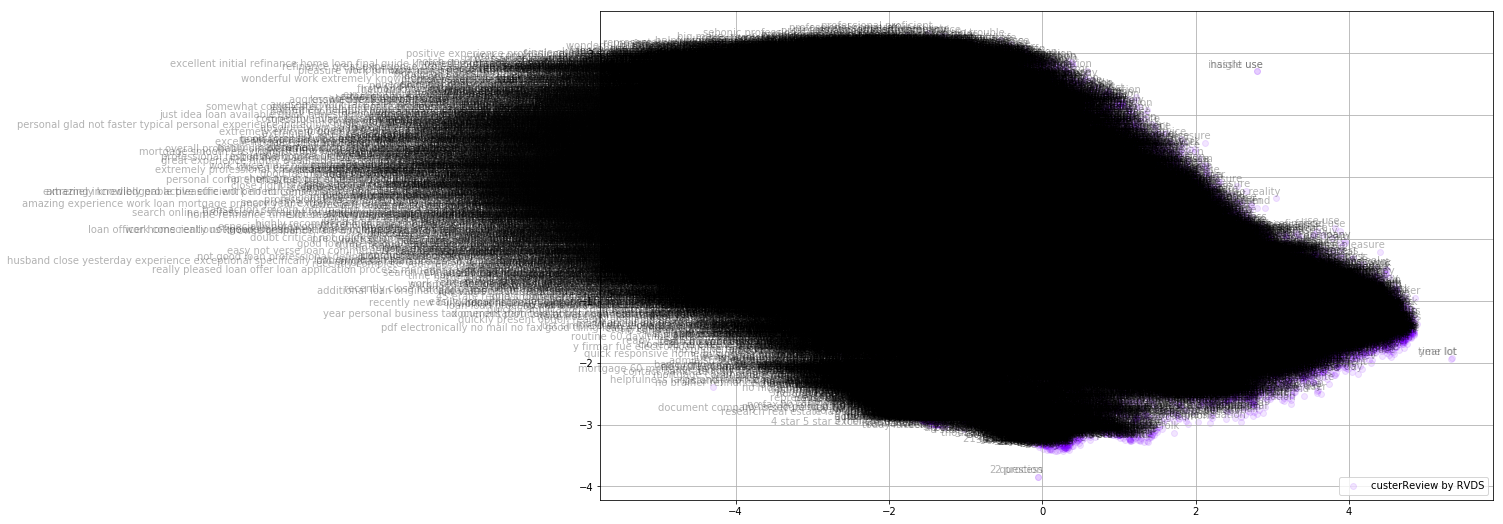

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# % matplotlib inline

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(nouns_vec_df.values)


def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
# tsne_plot_2d('custerReview by RVDS', tsne_results, list(nouns_vec_df.index),a=0.1)

# Aspect-based mining

In [234]:
# sent_list = []
# for doc in nlp.pipe(cr_df.REVIEWTEXT.astype('unicode').values[:1000], batch_size=1000, n_threads=-1):
#     sent_list.extend(list(doc.sents))

# sent_list[:10]
nounchunks = []
for doc in nlp.pipe(cr_df.REVIEWTEXT.astype('unicode').values[:1000], batch_size=1000, n_threads=-1):
    nounchunks.extend(list(doc.noun_chunks))
#     nouns_vec_dict.update({tk.text:tk.vector for tk in doc.noun_chunks if len(tk.text.split())>1 and tk.has_vector})


In [285]:

Amod_Nsubj_toVec = {}
Nsubj_toVec = {}
for nouns in list(set(nounchunks)):
    for token in nouns:
        if token.dep_ =='amod'and token.head.dep_!='nsubj':
            key = " ".join([token.lemma_, token.head.lemma_])
            if key not in Amod_Nsubj_toVec.keys():
                Amod_Nsubj_toVec[key] = token.vector +  token.head.vector
            
            Nsubj.append(token.head.lemma_)
            if token.head.lemma_ not in Nsubj_toVec.keys():
                Nsubj_toVec[token.head.lemma_] = token.head.vector
                
from collections import Counter
cnt = Counter(Nsubj)
cnt.most_common(30)

[('rate', 478),
 ('experience', 298),
 ('process', 226),
 ('time', 191),
 ('service', 130),
 ('company', 104),
 ('loan', 98),
 ('lender', 90),
 ('job', 86),
 ('home', 86),
 ('mortgage', 70),
 ('cost', 54),
 ('document', 54),
 ('review', 52),
 ('option', 48),
 ('bank', 48),
 ('question', 44),
 ('response', 42),
 ('refinance', 42),
 ('purchase', 40),
 ('deal', 40),
 ('contact', 36),
 ('people', 34),
 ('transaction', 34),
 ('officer', 34),
 ('manner', 34),
 ('communication', 34),
 ('information', 32),
 ('thing', 30),
 ('refi', 28)]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 417 samples in 0.000s...
[t-SNE] Computed neighbors for 417 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 417 / 417
[t-SNE] Mean sigma: 0.167287
[t-SNE] KL divergence after 250 iterations with early exaggeration: 290.636871
[t-SNE] KL divergence after 1000 iterations: 0.909284


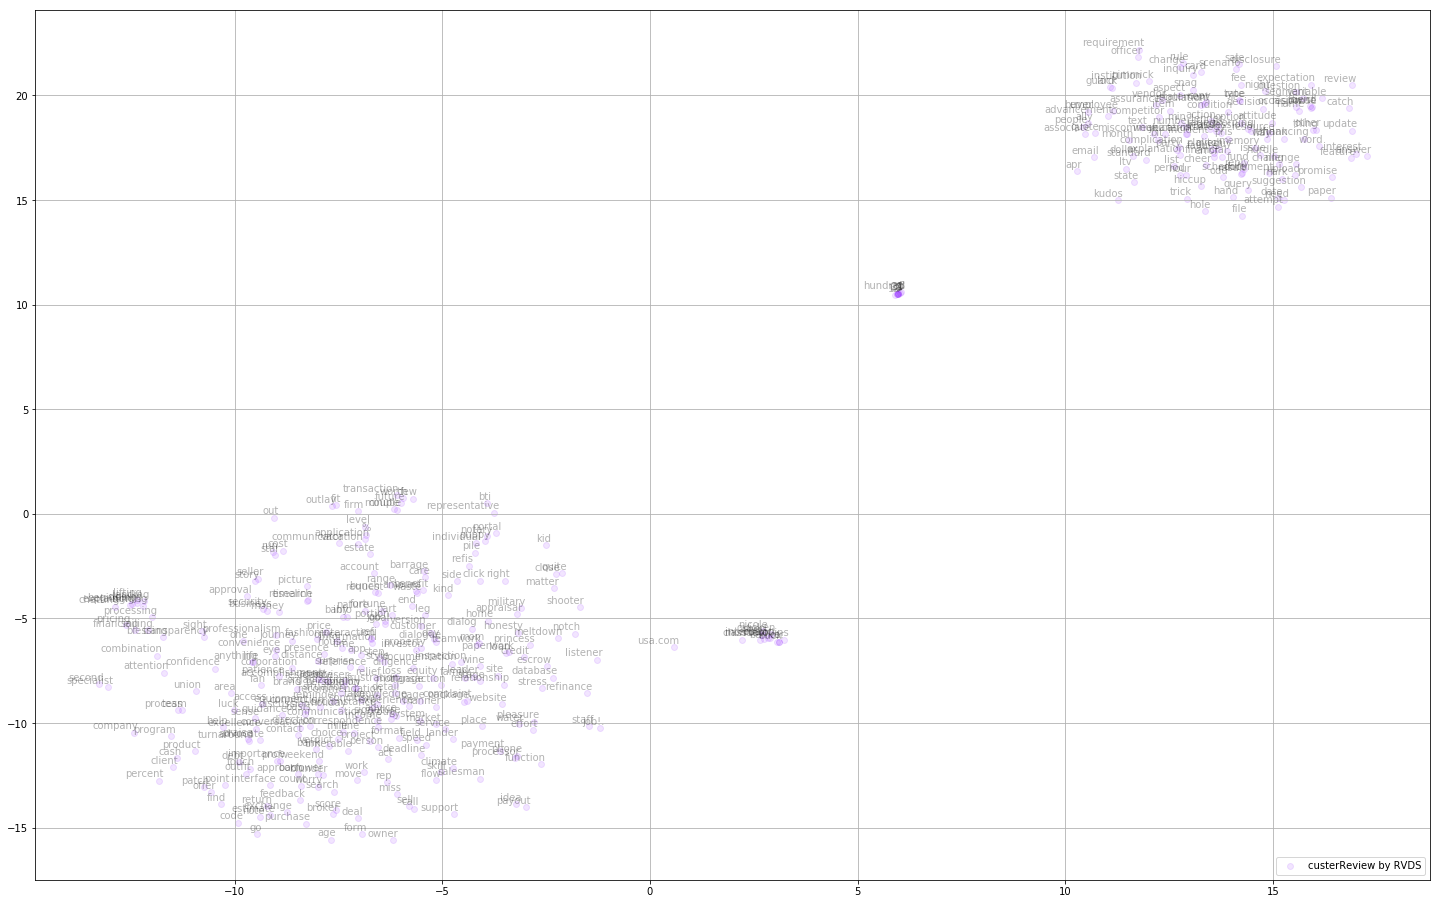

In [286]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# % matplotlib inline

tsne = TSNE(n_components=2, metric = 'cosine', early_exaggeration=40, learning_rate = 300, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(list(Nsubj_toVec.values()))


def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(25, 16))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
tsne_plot_2d('custerReview by RVDS', tsne_results, list(Nsubj_toVec.keys()),a=0.1)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 417 samples in 0.000s...
[t-SNE] Computed neighbors for 417 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 417 / 417
[t-SNE] Mean sigma: 0.167287
[t-SNE] KL divergence after 250 iterations with early exaggeration: 131.031631
[t-SNE] KL divergence after 300 iterations: 4.369047


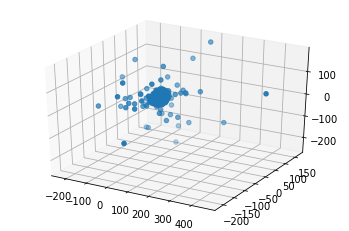

In [288]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

tsne3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, metric='cosine')
tsne3d_results = tsne3d.fit_transform(list(Nsubj_toVec.values()))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne3d_results))
plt.show()